In [5]:
# Общие библиотеки
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import json
from math import sin, cos

# Для создания и обучения модели
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

# Для работы с изображениями
import cv2
from PIL import Image

# Для визуализации
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
path_to_model_weights = "drive/MyDrive/Colab Notebooks/db2022/content/model/model_1_alld.pth"

In [8]:
json_dir = "drive/MyDrive/Colab Notebooks/db2022/content/json/"

data_df = pd.DataFrame({'id': [], "left_top_x": [], 'left_top_y': [], "right_bottom_x": [], 'right_bottom_y': [], 'angle': []})

json_true = []
for _, _, files in os.walk(json_dir):
    for x in files:
        if x.endswith(".json"):
            data = json.load(open(json_dir + x))
            new_row = {'id':x.split(".")[0]+".png", 'left_top_x':data["left_top"][0], 'left_top_y':data["left_top"][1], 'right_bottom_x': data["right_bottom"][0], "right_bottom_y": data["right_bottom"][1], 'angle': data["angle"]}
            data_df = data_df.append(new_row, ignore_index=True)

data_df.head(5)

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,angle
0,1029.png,4359.0,2801.0,3092.0,3504.0,106.0
1,1009.png,3688.0,6298.0,3889.0,4863.0,233.0
2,1027.png,4548.0,2431.0,4699.0,3872.0,39.0
3,1011.png,6273.0,5116.0,7672.0,5491.0,330.0
4,1.png,8533.0,2184.0,9834.0,2819.0,341.0


In [9]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['left_top_x']/10496, 
                                                            self.data_df.iloc[idx]['left_top_y']/10496, 
                                                            self.data_df.iloc[idx]['right_bottom_x']/10496, 
                                                            self.data_df.iloc[idx]['right_bottom_y']/10496, 
                                                            self.data_df.iloc[idx]['angle']/360]

        #print(image_name)  
        # читаем картинку. read the image
        image = cv2.imread(f"drive/MyDrive/Colab Notebooks/db2022/content/train/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)

In [10]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [11]:
from os import listdir

print("Обучающей выборки " ,len(listdir("drive/MyDrive/Colab Notebooks/db2022/content/train")))
print("Тестовой выборки " ,len(listdir("drive/MyDrive/Colab Notebooks/db2022/content/test")))

#Обучающей выборки 800
#Тестовой выборки 400

Обучающей выборки  800
Тестовой выборки  400


In [12]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
#train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

In [13]:
#train_dataset = ImageDataset(train_df, train_transform)
#valid_dataset = ImageDataset(valid_df, valid_transform)

train_dataset = ImageDataset(data_df, train_transform)

In [14]:
batch_size= 16

In [15]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size= batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

#valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
#                                           batch_size= batch_size,
#                                           # shuffle=True,
#                                           pin_memory=True,
#                                           num_workers=2)

In [16]:
def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):

    x_center_true = np.array((data_true[0] + data_true[2])/2).astype(int)
    y_center_true = np.array((data_true[1] + data_true[3])/2).astype(int)

    x_metr = x_center_true - np.array((data_pred[0] + data_pred[2])/2).astype(int)
    y_metr = y_center_true - np.array((data_pred[1] + data_pred[3])/2).astype(int)

    metr =  1 - 0.7 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW)/2 + 0.3 *abs(data_pred[4] - data_true[4])/359
    return metr

In [17]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [18]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH, lr_scheduler):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = []

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append((loss.data.cpu().detach().numpy() / y_pred.size(0)) * 100)
            
            y_pred[:, :4] = y_pred[:, :4] * 10496
            y_pred[:, -1] = y_pred[:, -1] * 360

            labels[:, :4] = labels[:, :4] * 10496
            labels[:, -1] = labels[:, -1] * 360

            for label, pr in zip(labels, y_pred):
                    train_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

            optimizer.step()

        train_acc_log.append(train_pred)

        epoch_train_loss = (train_loss / train_size)*100
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, path_to_model_weights)

        val_loss = 0.
        val_size = 0
        
        val_pred = []
        
        lr_scheduler.step()


        model.eval()
        
        #with torch.no_grad():
        #    for imgs, labels in test_dataloader:
                
        #        imgs = imgs.cuda()
        #        labels = labels.cuda()
                
        #        pred = model(imgs)
        #        loss = criterion(pred, labels)

        #        pred[:, :4] = pred[:, :4] * 10496
        #        pred[:, -1] = pred[:, -1] * 360

        #        labels[:, :4] = labels[:, :4] * 10496
        #        labels[:, -1] = labels[:, -1] * 360
                
        #        val_loss += loss.item()
        #        val_size += pred.size(0)

        #        for label, pr in zip(labels, pred):
        #            val_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

        #val_loss_log.append((val_loss / val_size)*100)
        #val_acc_log.append(val_pred)

        clear_output()
        #plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_loss_log, 'loss')


        print('Train loss:', (train_loss / train_size)*100)
        #print('Val loss:', (val_loss / val_size)*100)
        print('Train metric:', (np.mean(train_pred)))
        #print('Val metric:', (np.mean(val_pred)))

    #return train_loss_log, train_acc_log, val_loss_log, val_acc_log    
    return train_loss_log, train_acc_log

In [19]:
torch.cuda.empty_cache()

# Подргружаем модель

#model = models.resnet50(pretrained=True)
#model = models.resnet152(pretrained=True)
#model = models.wide_resnet50_2(pretrained=True)
#model = models.wide_resnet101_2(pretrained=True)
#model = models.resnet101(pretrained=True)


model = models.resnet101(pretrained=True)

model.fc = nn.Linear(2048, 5)

model = model.cuda()
#criterion = torch.nn.MSELoss()
criterion =  nn.SmoothL1Loss()

optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9, verbose=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/20 [01:08<?, ?it/s]


ValueError: ignored

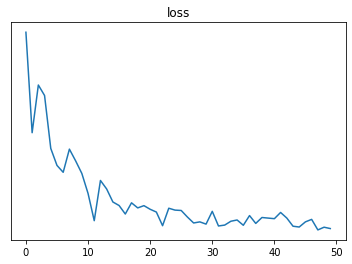

In [20]:
#train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, criterion, optimizer, train_loader, valid_loader, 20, lr_scheduler)
train_loss_log, train_acc_log = train(model, criterion, optimizer, train_loader, train_loader, 20, lr_scheduler)

In [21]:
total_metric = []

#for imgs, labels in valid_loader:
#    imgs = imgs.cuda()
#    labels = labels.cpu().detach().numpy()            
#    pred = model(imgs)
#    pred = pred.cpu().detach().numpy()    

#    pred[:, :4] = pred[:, :4] * 10496
#    pred[:, -1] = pred[:, -1] * 360

#    labels[:, :4] = labels[:, :4] * 10496
#    labels[:, -1] = labels[:, -1] * 360
    
#    for label, pr in zip(labels, pred):
#        total_metric.append(compute_metric(label, pr))
    
#total_metric = np.mean(total_metric)
#print('Valid metric:', total_metric)

#Valid metric: 0.9801261833663446

In [22]:
class TestImageDataset(Dataset):
    def __init__(self, files, transform=None):

        self.files = files
        self.transform = transform

    def __getitem__(self, idx):

        image_name = self.files[idx]

        # читаем картинку. read the image
        image = cv2.imread(f"drive/MyDrive/Colab Notebooks/db2022/content/test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.files)

In [23]:
test_images_dir = 'drive/MyDrive/Colab Notebooks/db2022/content/test/'

for _, _, test_files in os.walk(test_images_dir):
    
    break

test_dataset = TestImageDataset(test_files, valid_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size= batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                           )

In [24]:
indexes = [x.split('.')[0] for x in test_files]
preds = []

for imgs in test_loader:
    imgs = imgs.cuda()            
    pred = model(imgs)
    pred = pred.cpu().detach().numpy()
    pred[:, :4] = np.clip(pred[:, :4] * 10496, 0, 10496)
    pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
    preds.extend(list(pred))

In [25]:
sub_dir = "drive/MyDrive/Colab Notebooks/db2022/content/submission_m1_alld/"
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

json_true = []

for indx, pred in zip(indexes, preds):

    pred = [int(x) for x in pred]

    left_top = [pred[0], pred[1]]
    right_top = [pred[2], pred[1]]
    left_bottom = [pred[0], pred[3]]
    right_bottom = [pred[2], pred[3]]
        
    res = {
        'left_top': left_top,
        'right_top': right_top,
        'left_bottom': left_bottom,
        'right_bottom': right_bottom,
        'angle': pred[4]
    }

    with open(sub_dir+indx+'.json', 'w') as f:
        json.dump(res, f)